In [1]:
import shap
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import shap
from pathlib import Path
import pickle

c:\Users\harsh\anaconda3\envs\mlops\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = pickle.load(open("E://IUB//Explainable-AI-Fraud-Detection//models//test_bestmodel.pkl", "rb"))
model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Married', 'Home',
                                                   'Social Profile',
                                                   'Loan Category',
                                                   'Employmet type',
                                                   'Is_verified']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'F',
                                                                              'G',
                                                                              'Z'],
                                                                             ['0',
                                                                              '<1',
                                                                              '1-2',
                                                                              '2-3',
                                                                              '3-5',
                                                                              '5-10',
                                                                              '10+']]),
                                                  ['Tier of Employme...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               lambda=6.781499442018913e-07,
                               learning_rate=0.020331502249738863, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=49,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, ...))])

In [3]:
model.named_steps['calssifier']

XGBClassifier(alpha=0.010264780328603491, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.862578006645343, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.030525887866591526,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=6.781499442018913e-07,
              learning_rate=0.020331502249738863, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=49, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [4]:
test_data = pd.read_csv("E://IUB//Explainable-AI-Fraud-Detection//data//interim//test_data.csv")

In [5]:
test_x = test_data.iloc[:,:-1]
test_y = test_data.iloc[:,-1]

In [6]:
from sklearn.metrics import classification_report, confusion_matrix


# Make predictions on the test data
y_pred = model.predict(test_x)

# Print classification metrics
print("Classification Report:")
print(classification_report(test_y, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(test_y, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     19509
           1       0.98      0.97      0.98     19567

    accuracy                           0.98     39076
   macro avg       0.98      0.98      0.98     39076
weighted avg       0.98      0.98      0.98     39076

Confusion Matrix:
[[19135   374]
 [  585 18982]]


**Understanding of False Positive and False Negative in the case of loan Default**

*False Positives*

- If the model generates a high number of false positives due to biases, it may incorrectly classify deserving borrowers as high-risk. I belive that Biases in the data or model can disproportionately affect certain groups, leading to the denial of loans to individuals who are actually creditworthy. This not only hampers opportunities for those individuals but also results in missed business opportunities for the lending institution.

- False positives can also result in customer dissatisfaction and harm the reputation of the lending institution. Applicants who are wrongly classified as default risks may feel unfairly treated, leading to loss of trust and potential business for the institution.

- Processing loan applications that are eventually rejected due to false positives can impose additional operational costs on the lending institution, impacting efficiency and profitability

*False Negatives*

- If the model generates a high number of false negatives, it may grant loans to borrowers who are likely to default. This can result in increased loan defaults and financial losses for the lending institution.
- Granting loans to borrowers who are likely to default can raise concerns from regulatory bodies, potentially leading to penalties, legal issues, or damage to the reputation of the lending institution.

**Illustrating the impact of both (FP and FN) on the  business**


False Positives (FP): False positives occur when the model predicts a loan as default, but it actually is a non-default. In the given confusion matrix, the FP value is 374. False positives can have the following impacts:

False Negatives (FN): False negatives occur when the model predicts a loan as non-default, but it actually is a default. In the given confusion matrix, the FN value is 585. False negatives can have the following impacts:


To illustrate the impact, let's consider some hypothetical values for the cost of loss:

Cost of FP: 10,000 (Let's assume that the average amount of loan given to the customer is more than 10,000 and a lending institution will lose 10,000 on average if someone doesn’t default. This is the cost associated with incorrectly classifying a loan as default)

Cost of FN: 50,000 (Let's assume that the average amount of loan given to the customer is more than 50,000, and a lending institution will lose 50,000 on average if someone default. This is the cost associated with incorrectly classifying a loan as non-default)
Using these values, we can calculate the total cost of errors based on the confusion matrix:

Total Cost = (FP * Cost of FP) + (FN * Cost of FN)

Total Cost = (374 * 10,000) + (585 * 50,000)

Total Cost = 33.99 million

Here, The total cost of errors depends on the specific cost values assigned to FP and FN and can help assess the financial impact of misclassifications in the loan default use case. 
So, by adjusting the cost values, organizations can prioritize minimizing the type of error that incurs higher financial losses and optimize their model accordingly.


**Analysis on the Optimization**
- The cost of giving a loan to potential defaulters is 50,000 * 858 = 29.25 million. This cost represents the potential loss incurred when loans are granted to individuals who are likely to default.
- The cost of not giving the loan to non-defaulters is 10,000 * 374 = 3.74 million. This cost represents missed business opportunities and potential revenue when loans are denied to individuals who would not default.
- Considering the higher cost associated with giving loans to potential defaulters, it becomes a priority for us to tune the model to reduce false negatives. This implies that the focus should be on improving both precision and recall for non-defaulters.
We can tell the data scientists that we have to reduce FN to increase the precision and recall for non-defaulters.
- Ultimately, the goal is to strike a balance between minimizing the risk of default by accurately identifying potential defaulters while avoiding unnecessary loan denials to creditworthy individuals. This strategy can help mitigate losses and ensure responsible lending practices, benefiting both the lending institution and its customers.


**Understanding the Issues**
- False positives are the individuals who deserve the loan but were incorrectly classified as defaulters. We calculated the cost of denying the loan to them as 3.74 million. It is important to minimize false positives to avoid denying loans to deserving individuals.
- Denying loans to deserving individuals raises concerns about potential bias in the model. We need to ensure that the model is not biased against certain groups based on factors such as gender or age. Compliance with regulations requires fair lending practices.
- False negatives are the individuals who do not deserve the loan but were incorrectly classified as non-defaulters by the model. We calculated the cost of giving loans to potential defaulters as $29.25 million. Business stakeholders are particularly concerned about false negatives and aim to reduce them to improve return on investment (ROI).
- To achieve high ROI, it is crucial to understand how we can effectively reduce false negatives. By minimizing false negatives, the business can identify more potential defaulters and make informed lending decisions.

**SHAP**

In [7]:
encoder_step = model.named_steps['preprocess']
df_test_transform = encoder_step.transform(test_data)
feature_names = encoder_step.get_feature_names_out()
df_test_transform = pd.DataFrame(df_test_transform, columns=feature_names)
df_test_transform.head()
df_test_transform.columns

Index(['ohe__Gender_Female', 'ohe__Gender_Male', 'ohe__Gender_Other',
       'ohe__Married_No', 'ohe__Married_Yes', 'ohe__Married_missing',
       'ohe__Home_mortgage', 'ohe__Home_none', 'ohe__Home_other',
       'ohe__Home_own', 'ohe__Home_rent', 'ohe__Social Profile_No',
       'ohe__Social Profile_Yes', 'ohe__Social Profile_missing',
       'ohe__Loan Category_Business', 'ohe__Loan Category_Car ',
       'ohe__Loan Category_Consolidation', 'ohe__Loan Category_Credit Card',
       'ohe__Loan Category_Home', 'ohe__Loan Category_Medical ',
       'ohe__Loan Category_Other ', 'ohe__Employmet type_Salaried',
       'ohe__Employmet type_Self - Employeed', 'ohe__Employmet type_missing',
       'ohe__Is_verified_Not Verified', 'ohe__Is_verified_Source Verified',
       'ohe__Is_verified_Verified', 'ohe__Is_verified_missing',
       'ord__Tier of Employment', 'ord__Work Experience', 'remainder__Amount',
       'remainder__Interest Rate', 'remainder__Tenure(years)',
       'remainder__Total I

In [17]:
def filter_test_data_based_actual_prediction(test_x, test_y,y_pred, actual, prediction ):

  ## Filter False negatives

  # Convert the numpy array to a pandas Series
  Predictions = pd.Series(y_pred, name='Predictions')

  # Merge the Series with the DataFrame
  test_y= test_y.rename('Actual')

  #print(test_y)

  merged_df = pd.concat([test_y, Predictions], axis=1)

  #print(merged_df)

  filtered_df = merged_df[(merged_df['Actual'] == actual) & (merged_df['Predictions'] == prediction)]


  # Get the index of the filtered_df
  filtered_index = filtered_df.index

  # Filter the test_x DataFrame based on the same index
  filtered_test_x = test_x.loc[filtered_index]

  # Concatenate test_x and filtered_df along the columns axis
  concatenated_df = pd.concat([filtered_test_x, filtered_df], axis=1)


  # Split the data into features (X) and labels (y)
  test_x_FP = concatenated_df.drop(['Predictions', 'Actual'], axis=1) 
  test_y_FP = concatenated_df['Actual'] 

  return test_x_FP, test_y_FP



In [ ]:
test_x_FP, test_y_FP= filter_test_data_based_actual_prediction(df_test_transform, test_y, y_pred, actual=0, prediction=1 )


### Global Level

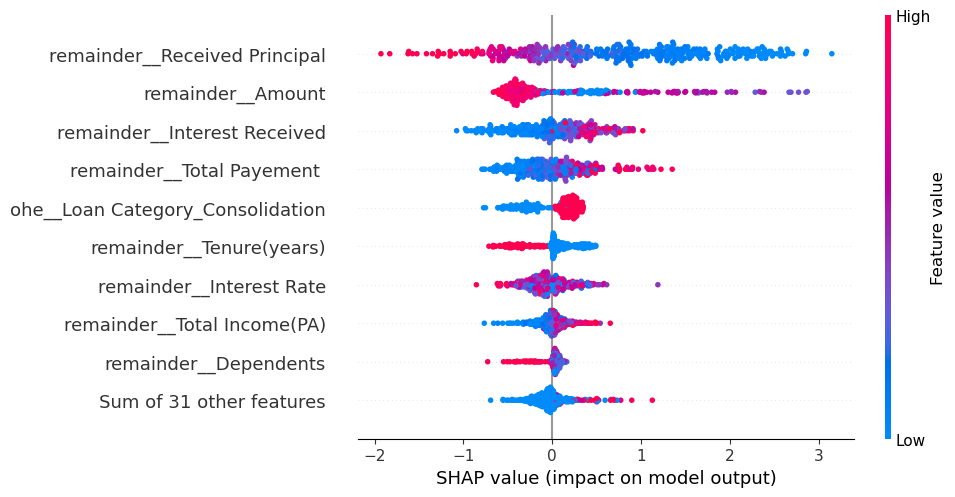

In [9]:
# Creating a SHAP TreeExplainer
explainer = shap.TreeExplainer(model.named_steps['calssifier'])

# Calculating SHAP values for the testing data

dmatrix_test = xgb.DMatrix(df_test_transform, enable_categorical=True) 

shap_values = explainer(test_x_FP)

# summarizing he effects of all the features
shap.plots.beeswarm(shap_values)
# shap.plots.bar(shap_values)

- To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. 
- The plot above sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output.
- The color represents the feature value (red high, blue low). 
- This reveals for example that a high Principal Received lowers the predicted default probability.

In [ ]:
columns_to_view = ['remainder__Received Principal', 'remainder__Amount',  'remainder__Interest Received' , 'remainder__Total Payement ',
                   'ohe__Loan Category_Consolidation', 'remainder__Tenure(years)', 'remainder__Interest Rate', 
       'remainder__Total Income(PA)', 'remainder__Dependents',
       'remainder__Delinq_2yrs', 'remainder__Number of loans']



for i in columns_to_view:
    shap.plots.scatter(shap_values[: , i], color=shap_values)

#### For False positives

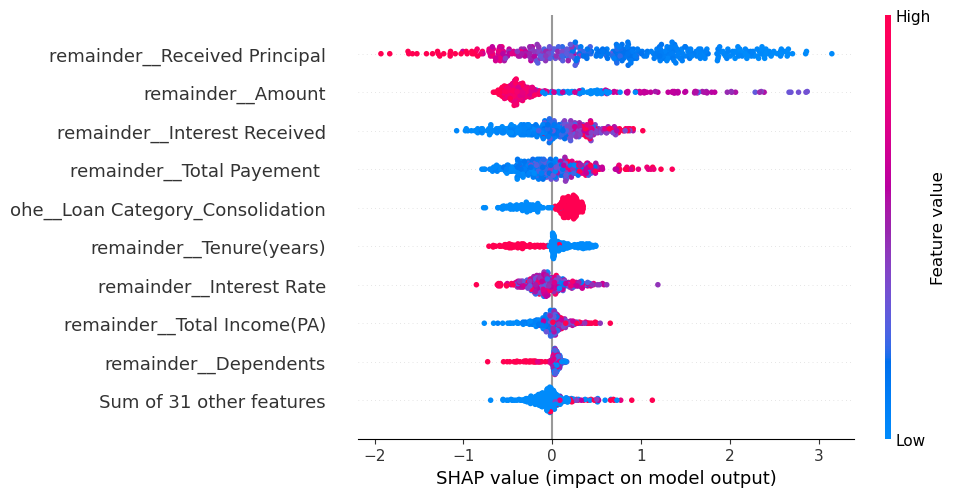

In [10]:


# Creating a SHAP TreeExplainer
explainer = shap.TreeExplainer(model.named_steps['calssifier'])

# Calculating SHAP values for the testing data

dmatrix_test = xgb.DMatrix(test_x_FP, enable_categorical=True) 

shap_values = explainer(test_x_FP)

# summarizing he effects of all the features
shap.plots.beeswarm(shap_values)
# shap.plots.bar(shap_values)

In [ ]:
# creating a dependence scatter plot to show the effect of a single feature across the whole dataset


columns_to_view = ['remainder__Received Principal', 'remainder__Amount',  'remainder__Interest Received' , 'remainder__Total Payement ',
                   'ohe__Loan Category_Consolidation', 'remainder__Tenure(years)', 'remainder__Interest Rate', 
       'remainder__Total Income(PA)', 'remainder__Dependents',
       'remainder__Delinq_2yrs', 'remainder__Number of loans']



for i in columns_to_view:
    shap.plots.scatter(shap_values[: , i], color=shap_values)

##### For False Negatives

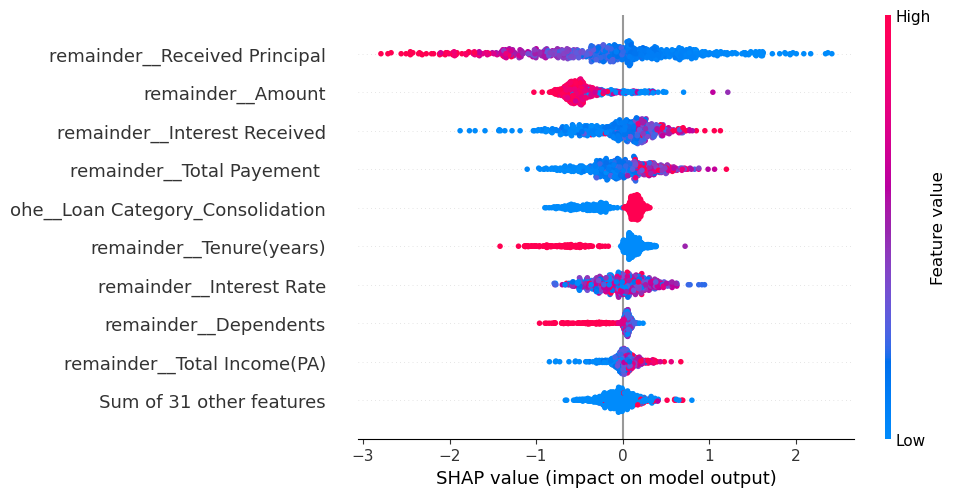

In [19]:
test_x_FN, test_y_FN= filter_test_data_based_actual_prediction(df_test_transform, test_y, y_pred, actual=1, prediction=0 )

# Create a SHAP TreeExplainer
explainer = shap.TreeExplainer(model.named_steps['calssifier'])

# Calculate SHAP values for the testing data

dmatrix_test = xgb.DMatrix(test_x_FN, enable_categorical=True) # Optional. Use if you have categorical data in processed data

shap_values = explainer(test_x_FN)

# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

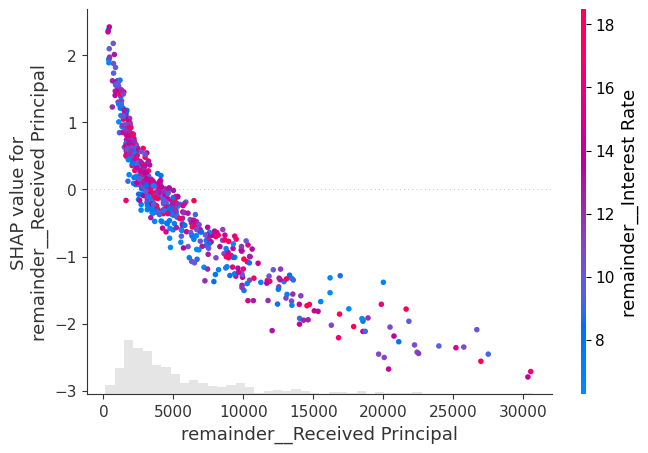

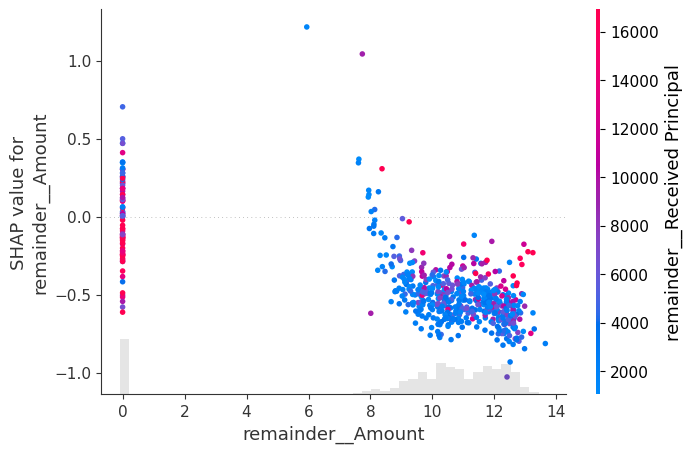

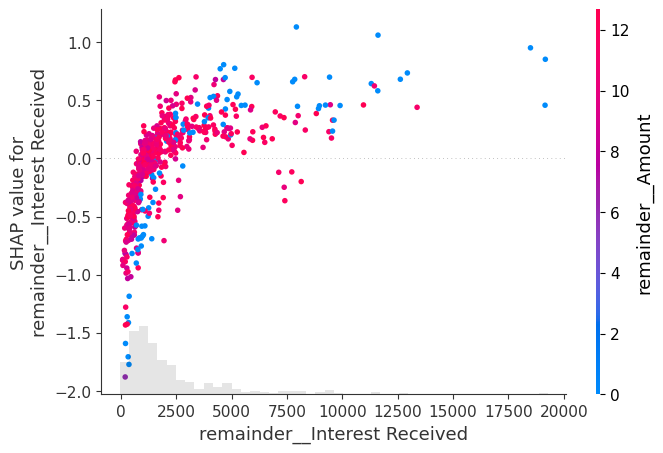

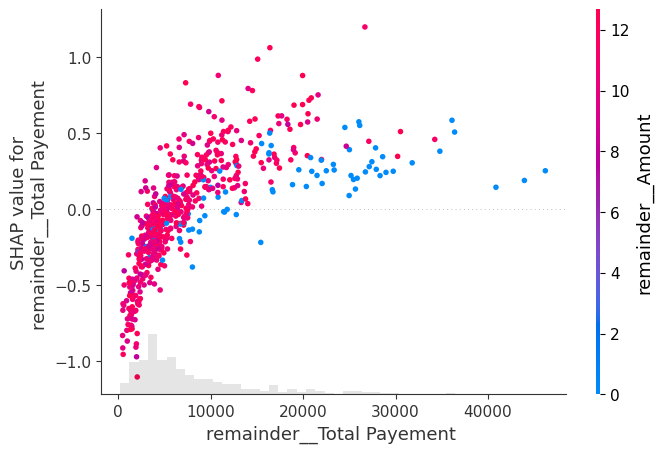

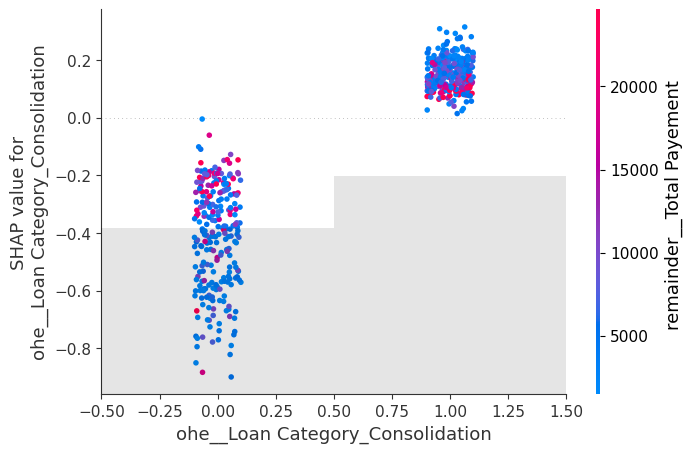

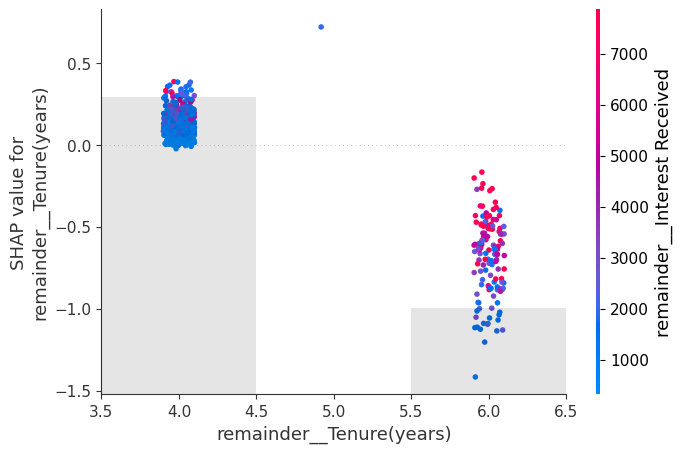

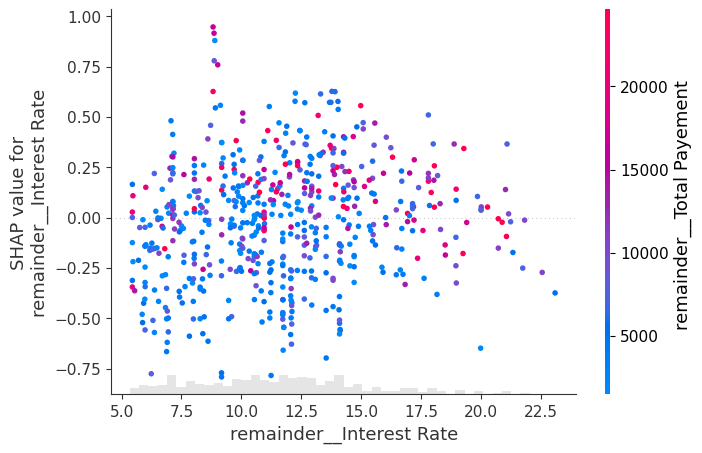

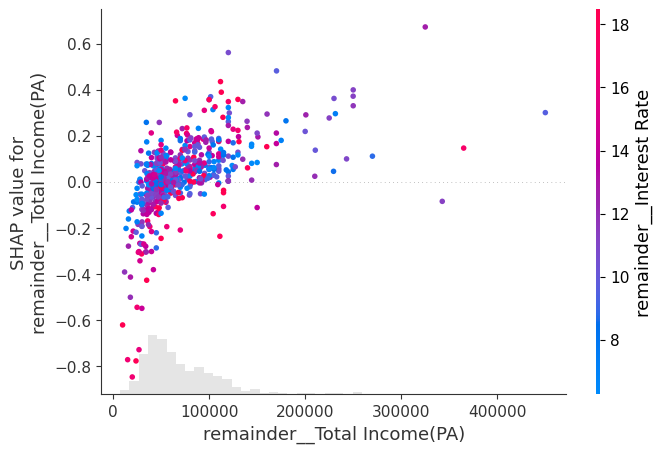

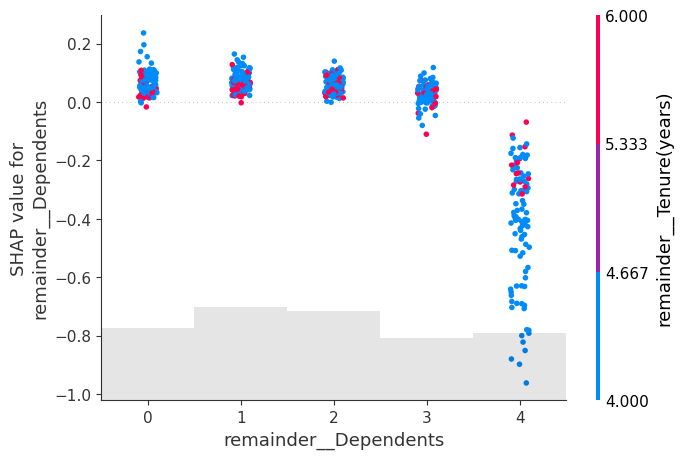

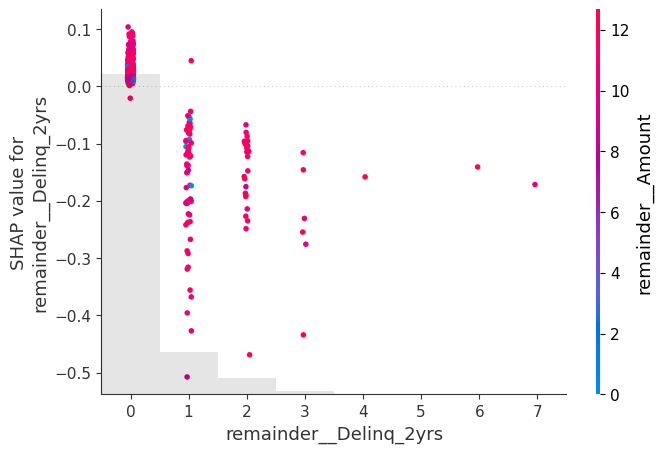

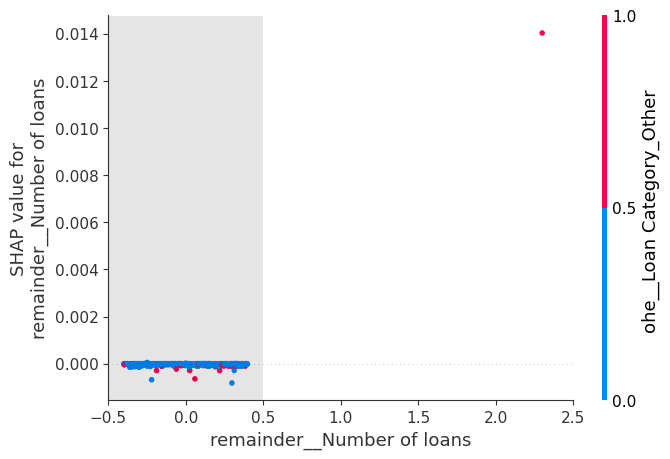

In [20]:
# creating a dependence scatter plot to show the effect of a single feature across the whole dataset


columns_to_view = ['remainder__Received Principal', 'remainder__Amount',  'remainder__Interest Received' , 'remainder__Total Payement ',
                   'ohe__Loan Category_Consolidation', 'remainder__Tenure(years)', 'remainder__Interest Rate', 
       'remainder__Total Income(PA)', 'remainder__Dependents',
       'remainder__Delinq_2yrs', 'remainder__Number of loans']



for i in columns_to_view:
    shap.plots.scatter(shap_values[: , i], color=shap_values)

##### Conclusion:
- We can see above that SHAP value (impact on the model output) decreases with the increase in the Received Principal amount.
- In the case of False Negatives "Dependant" feature is given more importance than the total amount, which is reversed in the case of False positive values.


#### Local Level

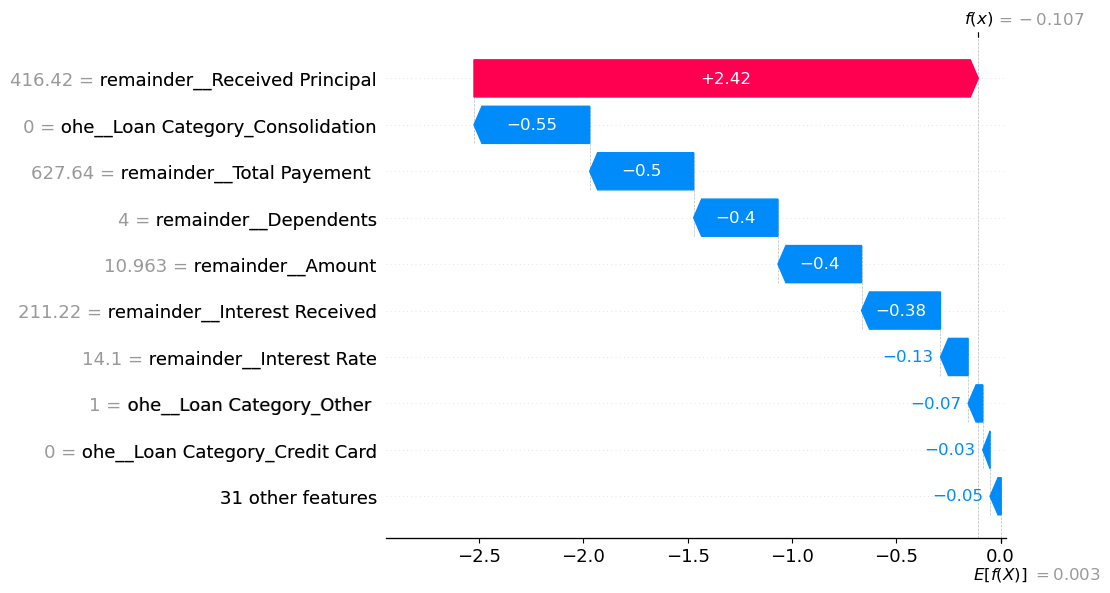

In [37]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[200])

#### How the above graph is useful?


**Stakeholders:**

- For example, we can compare two customers with different creditworthiness outcomes but similar values for most features.By highlighting the specific feature(s) that differ between the two customers, we can explain how that feature influenced the divergent predictions. This would help the stakeholders understand the relative importance of various factors in the creditworthiness assessment.
- By providing these personalized explanations at the individual level, we  can help business stakeholders understand how the model arrives at its decisions, gain insights into the factors influencing creditworthiness assessments, and make informed business decisions based on the model's findings.

**Regulators:**
- For ensuring that  ensuring that credit lending models are fair, transparent, and non-discriminatory we can select customers from different demographic groups (e.g., based on race, gender) and present local-level explanations to regulators. By highlighting the features that contribute to the predictions for each customer, we can demonstrate that the model's decisions are not based on discriminatory attributes. This would help the regulators gain confidence in the fairness of the model.
- We can provide local-level explanations for customers who have experienced adverse outcomes, such as being denied credit or receiving unfavorable terms. By analyzing the influential features for these customers, we can identify any potential biases or disparities in the model's decision-making. We can then explain to regulators how the model treats different customers fairly and ensure compliance with regulatory requirements.

## Anchors

In [44]:
# Getting he dataframe ready
train_data = pd.read_csv("E://IUB//Explainable-AI-Fraud-Detection//data//interim//train_data.csv")

train_x = train_data.iloc[:,:-1]
train_y = train_data.iloc[:,-1]


encoder_step = model.named_steps['preprocess']
df_train_transform = encoder_step.transform(train_data)
feature_names = encoder_step.get_feature_names_out()
df_train_transform = pd.DataFrame(df_train_transform, columns=feature_names)
df_train_transform.head()


Index(['ohe__Gender_Female', 'ohe__Gender_Male', 'ohe__Gender_Other',
       'ohe__Married_No', 'ohe__Married_Yes', 'ohe__Married_missing',
       'ohe__Home_mortgage', 'ohe__Home_none', 'ohe__Home_other',
       'ohe__Home_own', 'ohe__Home_rent', 'ohe__Social Profile_No',
       'ohe__Social Profile_Yes', 'ohe__Social Profile_missing',
       'ohe__Loan Category_Business', 'ohe__Loan Category_Car ',
       'ohe__Loan Category_Consolidation', 'ohe__Loan Category_Credit Card',
       'ohe__Loan Category_Home', 'ohe__Loan Category_Medical ',
       'ohe__Loan Category_Other ', 'ohe__Employmet type_Salaried',
       'ohe__Employmet type_Self - Employeed', 'ohe__Employmet type_missing',
       'ohe__Is_verified_Not Verified', 'ohe__Is_verified_Source Verified',
       'ohe__Is_verified_Verified', 'ohe__Is_verified_missing',
       'ord__Tier of Employment', 'ord__Work Experience', 'remainder__Amount',
       'remainder__Interest Rate', 'remainder__Tenure(years)',
       'remainder__Total I

In [57]:
import pandas as pd
from alibi.explainers import AnchorTabular

"""Initializing and training the anchor model"""
predict_fn = lambda x: model.named_steps['calssifier'].predict_proba(x)
explainer = AnchorTabular(predict_fn, feature_names=df_train_transform.columns)
# Fit the explainer with reference data
explainer.fit(df_train_transform.values)

"""Find Anchor of customer at index 0"""
idx = 1000 # record we would like to explain using anchors
class_names = ["No Default","Default"]

print('Prediction: ', class_names[explainer.predictor(df_train_transform[idx:idx+1].values)[0]])

explanation = explainer.explain(df_train_transform[idx:idx+1].values, threshold=0.95)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  No Default
Anchor: remainder__Received Principal > 8590.60 AND remainder__Interest Received <= 786.21 AND remainder__Interest Rate <= 10.54
Precision: 0.97
Coverage: 0.01


- Coverage:  Here the coverage is 1%, here we say that it covers 1% of the instances have the same anchor features(remainder__Received Principal > 8590.60 AND remainder__Interest Received <= 786.21 AND remainder__Interest Rate <= 10.54) but different other features. 

- Precision: How much our model predicted accurately out of the coverage instances. So here lets say out of those 1% instances (1800 instances), our model accurately predicted the outcome of not defaulter 97% of times.


**Conclusion:**

We can use Anchors to provide easy-to-understand explanations for specific credit lending decisions made by the model. 

For example:

- Let's say a customer was approved for a loan. As a Data Scienist we can use Anchors to identify the most influential features that led to the approval decision. We can create an anchor rule, such as If income is greater than X dollars and credit score is greater than Y, approve the loan. This rule highlights the key factors that contributed to the positive decision, making it easy for stakeholders to understand why the loan was approved.
- Similarly, if a customer was denied credit, Anchors can help us identify the decisive factors behind the denial. They can generate an anchor rule, such as If outstanding debt is greater than $x or employment length is less than T years, deny the loan. This rule clarifies the main reasons for the negative decision, it enable the stakeholders to understand the factors leading to the denial.

1823.55